In [ ]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Citizen Science Notebook</b> <br>
Contact author: Becky Nevin<br>
Last verified to run: 2024-01-04 <br>
LSST Science Pipelines version: Weekly 2023_47 <br>
Container size: small or medium <br>


**Description:**
Query and send variable star images and light curves (CURRENTLY NOT DOING LCs) from RSP to Zooniverse

**Skills:** Use various TAP tables, including joining multiple tables. Get calexp images. Extract time-series photometry.

**LSST Data Products:** TAP tables dp02_dc2_catalogs.MatchesTruth, TruthSummary, ForcedSource, CcdVisit<br>

**Packages:** astropy, lsst.daf.butler, lsst.afw.display, lsst.geom 

**Credit:** Tutorial notebooks 03a, 04a, 04b, 07b, and 08

**Support:** Support is available and questions are welcome - (cscience@lsst.org)

DEBUG VERSION note that this version of the notebook contains additional debugging and the first cell will need to be run once

## 1. Introduction <a class="anchor" id="first-bullet"></a>
This notebook will guide you through the process of sending images of variable stars from the Rubin Science Platform (RSP) to the Zooniverse.

### 1.1 Package imports <a class="anchor" id="second-bullet"></a>

#### Install Pipeline Package

First, install the Rubin Citizen Science Pipeline package by doing the following:

1. Open up a New Launcher tab
2. In the "Other" section of the New Launcher tab, click "Terminal"
3. Use `pip` to install the `rubin.citsci` package by entering the following command:
```
pip install rubin.citsci
```
4. Confirm the next cell containing `from rubin.citsci import pipeline` works as expected and does not throw an error

!pip install --upgrade --force-reinstall --no-deps rubin.citsci --quiet

In [1]:
from rubin.citsci import pipeline

In [2]:
import utils # this is not currently used but will be used when we migrate some of the plotting functions to utils
import matplotlib
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import gc # this is only used in remove_figure
import numpy as np
import pandas as pd
import os

# astropy imports
import astropy
from astropy.wcs import WCS
from astropy import units as u

import lsst.geom as geom

# image visualization routines
import lsst.afw.display as afwDisplay
# must explicitly set this to save figures
afwDisplay.setDefaultBackend("matplotlib")

### 1.2 Define functions and parameters <a class="anchor" id="third-bullet"></a>
If you haven't already, [make a Zooniverse account](https://www.zooniverse.org/accounts/registerhttps://www.zooniverse.org/accounts/register) and create your project.

IMPORTANT: Your Zooniverse project must be set to "public", a "private" project will not work. Select this setting under the "Visibility" tab, (it does not need to be set to live). 


A "slug" is the string of your Zooniverse username and your project name without the leading forward slash, for instance: "username/project-name". [Click here for more details](https://www.zooniverse.org/talk/18/967061?comment=1898157&page=1).


In [3]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)
email = "beckynevin@gmail.com"  
slug_name = "rebecca-dot-nevin/test-project" 

print("Running utilities to establish a link with Zooniverse")
print("Enter your Zooniverse username followed by password below")
cit_sci_pipeline = pipeline.CitSciPipeline()
cit_sci_pipeline.login_to_zooniverse(slug_name, email)

Running utilities to establish a link with Zooniverse
Enter your Zooniverse username followed by password below
Enter your Zooniverse credentials...


Username:  rebecca.nevin
 ········


You now are logged in to the Zooniverse platform.


## 2. Make a subject set of a variable star to send to Zooniverse <a class="anchor" id="fourth-bullet"></a>
A subject set is a collection of data (images, plots, etc) that are shown to citizen scientists. It is also the unit of data that is sent to Zooniverse.

Here, we curate the subject set of objects to send to Zooniverse. This can be modified to create your own subject set. Your subject set must have 100 objects or less in the testing phase before your project is approved by the EPO Data Rights panel. 

This example makes one set of image cutouts of a confirmed variable star at five different moments in time.

### 2.1 Initialize Butler

In [4]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
service, butler, skymap = utils.setup_butler(config, collection)

### 2.2 Familiarize yourself with the tables we'll be using
This includes the DiaObject table and the ForcedSourceOnDiaObject table. Note that these are _difference_ image tables, created by identifying objects not present in the template deepcoadd images. For more information, see https://lse-163.lsst.io/.


In [5]:
pd.set_option('display.max_rows', 200, 'display.max_colwidth', 1000)
results_diaobject = service.search("SELECT column_name, datatype, description,\
                          unit from TAP_SCHEMA.columns\
                          WHERE table_name = 'dp02_dc2_catalogs.DiaObject'")

In [6]:
results_diaobject.to_table().to_pandas()

,column_name,datatype,description,unit
0,decl,double,Mean Declination of DIASources in the diaObject,deg
1,diaObjectId,long,Unique id.,
2,gPSFluxChi2,double,Chi^2 statistic for the scatter of gPSFlux around gPSFluxMean,
3,gPSFluxErrMean,double,Mean of the diaSource PSF flux errors,
4,gPSFluxLinearIntercept,double,y-intercept of a linear model fit to diaSource PSF flux vs time,
5,gPSFluxLinearSlope,double,Slope of a linear model fit to diaSource PSF flux vs time,
6,gPSFluxMAD,double,Median absolute deviation of diaSource PSF flux. Does not include scale factor for comparison to sigma,
7,gPSFluxMax,double,Maximum diaSource PSF flux,
8,gPSFluxMaxSlope,double,Maximum ratio of time ordered deltaFlux / deltaTime,
9,gPSFluxMean,double,Weighted mean of diaSource PSF flux,


diaObjectId is the unique ID for each object in the table; note that these are different IDs from the ObjectId in the Object table. From https://lse-163.lsst.io/:

>There is no direct DIASource-to-Object match: in general, a time-domain object is not necessarily the same astrophysical object as a static-sky object, even if the two are positionally coincident (eg. an asteroid overlapping a galaxy). Therefore, adopted data model emphasizes that having a DIASource be positionally coincident with an Object does not imply it is physically related to it. Absent other information, the least presumptuous data model relationship is one of positional association, not physical identity.

We're currently lacking visit information, which we'll need for creating images of each visit. We can get from the ForcedSourceOnDiaObject table (below). 

In [7]:
results_forceddiaobject = service.search("SELECT column_name, datatype, description,\
                          unit from TAP_SCHEMA.columns\
                          WHERE table_name = 'dp02_dc2_catalogs.ForcedSourceOnDiaObject'")

In [8]:
results_forceddiaobject.to_table().to_pandas()

,column_name,datatype,description,unit
0,band,char,Abstract filter that is not associated with a particular instrument,
1,ccdVisitId,long,Unique ID of visit and detector for which forced photometry was performed. Primary Key of the CcdVisit Table.,
2,coord_dec,double,Fiducial ICRS Declination of DiaObject centroid used for database indexing,deg
3,coord_ra,double,Fiducial ICRS Right Ascension of DiaObject centroid used for database indexing,deg
4,diaObjectId,long,Unique DiaObject ID. Primary Key of the DiaObject Table,
5,forcedSourceOnDiaObjectId,long,Unique ID of forced source. Primary Key.,
6,localBackground_instFlux,double,Background in annulus around source,count
7,localBackground_instFluxErr,double,1-sigma uncertainty on the background in an annulus around source,count
8,localPhotoCalib,double,Local approximation of the PhotoCalib calibration factor at the location of the src.,
9,localPhotoCalib_flag,boolean,Set for any fatal failure,


Finally, let's examine the CcdVisit catalog, which we will match with the ForcedSourceOnDiaObject catalog in order to retrieve timing information of when the exposure was taken.

In [9]:
results_ccdvisit = service.search("SELECT column_name, datatype, description,\
                          unit from TAP_SCHEMA.columns\
                          WHERE table_name = 'dp02_dc2_catalogs.CcdVisit'")

In [10]:
results_ccdvisit.to_table().to_pandas()

,column_name,datatype,description,unit
0,band,char,Name of the band used to take the exposure where this source was measured. Abstract filter that is not associated with a particular instrument.,
1,ccdVisitId,long,Primary key (unique identifier).,
2,darkTime,double,"Average dark current accumulation time, accurate to 10ms.",s
3,decl,double,Declination of Ccd center.,deg
4,detector,long,Detector ID. A detector associated with a particular instrument (not an observation of that detector),
5,expMidpt,char,"Midpoint for exposure. TAI, accurate to 10ms.",
6,expMidptMJD,double,"Midpoint for exposure in MJD. TAI, accurate to 10ms.",d
7,expTime,double,"Spatially-averaged duration of exposure, accurate to 10ms.",s
8,llcdec,double,Declination of lower left corner.,deg
9,llcra,double,RA of lower left corner.,deg


In [11]:
del results_forceddiaobject, results_diaobject, results_ccdvisit

### 2.3 Do a search for variable stars
We will perform this search by joining the three catalogs we explored above.

For more details, please see the `DP02_07b_Variable_Star_Lightcurves.ipynb` notebook in the tutorial notebooks by Jeff Carlin and Ryan Lau. All the code in this section is derivative of that notebook.

We are using the coordinates of a known variable star.

In [12]:
ra_known_rrl = 62.1479031
dec_known_rrl = -35.799138

This query will return a massive list of sources, some of which are repeat object IDs.

In [13]:
query = "SELECT diao.diaObjectId, "\
        "fsodo.forcedSourceOnDiaObjectId, "\
        "diao.ra, diao.decl, "\
        "diao.gPSFluxNdata, "\
        "diao.gPSFluxStetsonJ, "\
        "diao.gTOTFluxMean, diao.gTOTFluxSigma, "\
        "scisql_nanojanskyToAbMag(fsodo.psfFlux) as psfMag, "\
        "fsodo.diaObjectId, "\
        "fsodo.ccdVisitId, fsodo.band, fsodo.psfFlux, fsodo.psfFluxErr, "\
        "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
        "cv.expMidptMJD, cv.detector, cv.visitId, "\
        "scisql_nanojanskyToAbMag(fsodo.psfFlux) as fsodo_gmag "\
        "FROM dp02_dc2_catalogs.DiaObject as diao "\
        "JOIN dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "\
        "ON fsodo.diaObjectId = diao.diaObjectId "\
        "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
        "WHERE diao.gTOTFluxSigma/diao.gTOTFluxMean > 0.25 "\
        "AND diao.gTOTFluxSigma/diao.gTOTFluxMean < 1.25 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) > 18 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) < 23 "\
        "AND diao.gPSFluxNdata > 30 "\
        "AND diao.gPSFluxStetsonJ > 20 "\
        "AND CONTAINS(POINT('ICRS', diao.ra, diao.decl), "\
        "CIRCLE('ICRS',"+str(ra_known_rrl)+", "+str(dec_known_rrl)+", 5)) = 1 "

results = service.search(query)
fsodo_sources = results.to_table()
fsodo_sources 

diaObjectId,forcedSourceOnDiaObjectId,ra,decl,gPSFluxNdata,gPSFluxStetsonJ,gTOTFluxMean,gTOTFluxSigma,psfMag,diaObjectId2,ccdVisitId,band,psfFlux,psfFluxErr,psfDiffFlux,psfDiffFluxErr,expMidptMJD,detector,visitId,fsodo_gmag
,,deg,deg,,,,,,,,,nJy,nJy,nJy,nJy,d,,,
int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64,int64,int64,float64
1569135034231685181,255761551896609660,67.4679316,-37.6786425,44.0,58.5283985,55256.3476307,21775.7201087,18.79021633751964,1569135034231685181,476393014,z,110640.3306486,915.1009256,20257.035671,926.5053408,60275.0778372,14,476393,18.79021633751964
1569135034231685181,98200731403682767,67.4679316,-37.6786425,44.0,58.5283985,55256.3476307,21775.7201087,19.25658781604804,1569135034231685181,182913116,i,72005.3678823,405.2336341,-21400.9500233,408.147903,59822.3150652,116,182913,19.25658781604804
1569135034231685181,517496349424355804,67.4679316,-37.6786425,44.0,58.5283985,55256.3476307,21775.7201087,21.41643843890607,1569135034231685181,963912065,u,9849.7367727,303.3428366,-350.5621579,312.3940369,60998.0744062,65,963912,21.41643843890607
1569135034231685181,410971505933945604,67.4679316,-37.6786425,44.0,58.5283985,55256.3476307,21775.7201087,18.897844665585446,1569135034231685181,765494082,g,100198.7108045,302.8162972,37734.4469405,282.5612919,60709.1402802,82,765494,18.897844665585446
1569135034231685181,643392030143154878,67.4679316,-37.6786425,44.0,58.5283985,55256.3476307,21775.7201087,18.896543164578144,1569135034231685181,1198411044,z,100318.893696,754.8897184,9954.3363644,763.5679458,61336.1317912,44,1198411,18.896543164578144
1569135034231685181,393933914520944665,67.4679316,-37.6786425,44.0,58.5283985,55256.3476307,21775.7201087,19.13749225115207,1569135034231685181,733759095,r,80353.1856934,358.3591287,-16955.0804756,358.4479202,60664.2225202,95,733759,19.13749225115207
1569135034231685181,517625217233717958,67.4679316,-37.6786425,44.0,58.5283985,55256.3476307,21775.7201087,19.31389569920872,1569135034231685181,964152100,r,68303.3052939,285.946852,-28226.858635,279.2815986,60998.1903862,100,964152,19.31389569920872
1569135034231685181,521763951336226972,67.4679316,-37.6786425,44.0,58.5283985,55256.3476307,21775.7201087,19.31736893356035,1569135034231685181,971861093,z,68085.1543852,569.1022837,-22541.4050574,555.9368936,61011.0736482,93,971861,19.31736893356035


List by unique source instead.

In [14]:
unique_variables = astropy.table.unique(fsodo_sources,keys = 'diaObjectId')['diaObjectId','ra','decl','expMidptMJD','band','ccdVisitId','visitId', 'detector']
unique_variables

diaObjectId,ra,decl,expMidptMJD,band,ccdVisitId,visitId,detector
,deg,deg,d,,,,
int64,float64,float64,float64,object,int64,int64,int64
1567428592185376787,59.4814837,-37.7323315,61254.3419842,y,1141195101,1141195,101
1567762843720221100,62.5202159,-37.8646632,60280.2057552,r,480303131,480303,131
1568246628836442456,62.5202159,-37.8646632,61017.0802592,g,975962163,975962,163
1568950316278219135,67.2951662,-38.4159654,60560.2826042,g,662526045,662526,45
1569082257673552562,67.0155078,-37.8278368,59914.1755432,r,242558012,242558,12
1569135034231685181,67.4679316,-37.6786425,60275.0778372,z,476393014,476393,14
1651510445384663056,62.6536501,-35.9700212,60185.3811712,z,426670023,426670,23
1651589610221862935,62.1479038,-35.7991348,60540.4073132,y,646739066,646739,66


### 2.4 Select one variable star
For the purposes of this tutorial, we will select one pre-ordained source. You can choose another, but be warned that many of these sources are not true variable stars.

In [15]:
diaobjectID = 1567428592185376787
selection = unique_variables[unique_variables["diaObjectId"]==diaobjectID]
ra = selection['ra'].value[0]
dec = selection['decl'].value[0]
print('ra and dec of variable star', ra, dec)

ra and dec of variable star 59.4814837 -37.7323315


### 2.5 Select some moments in time
To do this, we'll need to go back to the original table to get all of the necessary information you need to plot a series of images, including visit information.

In [16]:
source = fsodo_sources[fsodo_sources["diaObjectId"]==diaobjectID]['diaObjectId','ra','decl','ccdVisitId','visitId',
                                                         'band','psfFlux','psfFluxErr',
                                                         'expMidptMJD','detector','psfMag']
source

diaObjectId,ra,decl,ccdVisitId,visitId,band,psfFlux,psfFluxErr,expMidptMJD,detector,psfMag
,deg,deg,,,,nJy,nJy,d,,
int64,float64,float64,int64,int64,object,float64,float64,float64,int64,float64
1567428592185376787,59.4814837,-37.7323315,1141195101,1141195,y,217274.9132152,1755.4059358,61254.3419842,101,18.05747603718028
1567428592185376787,59.4814837,-37.7323315,1212153079,1212153,i,220985.9696981,590.3284039,61364.2925662,79,18.039088246512566
1567428592185376787,59.4814837,-37.7323315,662532066,662532,g,196440.0949505,433.4549124,60560.2854312,66,18.16692466155384
1567428592185376787,59.4814837,-37.7323315,909782131,909782,r,195614.2995458,482.6527048,60905.3085432,131,18.171498502873554
1567428592185376787,59.4814837,-37.7323315,1047475123,1047475,z,275528.8518518,935.3058406,61118.0144062,123,17.799582293809436
1567428592185376787,59.4814837,-37.7323315,904789050,904789,y,283345.1047675,1523.756618,60899.4044252,50,17.769210715195413
1567428592185376787,59.4814837,-37.7323315,676185120,676185,r,209555.5588523,490.1820967,60583.3096732,120,18.09675203551415
1567428592185376787,59.4814837,-37.7323315,266167081,266167,y,289677.4273541,1792.3334894,59950.1359082,81,17.74521336293549


Create a function that will select by band.


In [17]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

pick = {}
for filter in plot_filter_labels:
    pick[filter] = (source['band'] == filter)

From now on, we'll only consider the r-band images.

In [18]:
# also select some key moments in time
# begin by ordering by mjd
print(type(source[pick['r']]))
select_r = source[pick['r']]
sorted_sources = select_r[select_r['expMidptMJD'].argsort()]
sorted_sources



<class 'astropy.table.table.Table'>


diaObjectId,ra,decl,ccdVisitId,visitId,band,psfFlux,psfFluxErr,expMidptMJD,detector,psfMag
,deg,deg,,,,nJy,nJy,d,,
int64,float64,float64,int64,int64,object,float64,float64,float64,int64,float64
1567428592185376787,59.4814837,-37.7323315,40327030,40327,r,258575.9147688,535.0198784,59634.0870892,30,17.86852982557396
1567428592185376787,59.4814837,-37.7323315,193147032,193147,r,207715.9826285,497.251246,59839.3340712,32,18.10632521388235
1567428592185376787,59.4814837,-37.7323315,193148018,193148,r,208104.7777051,490.872577,59839.3345202,18,18.1042948726672
1567428592185376787,59.4814837,-37.7323315,193187002,193187,r,202320.5385648,491.5006487,59839.3530702,2,18.134900068992444
1567428592185376787,59.4814837,-37.7323315,193848097,193848,r,232671.7968929,499.4616498,59840.2471442,97,17.983140640366102
1567428592185376787,59.4814837,-37.7323315,202591070,202591,r,380253.6030788,636.4953924,59854.2787212,70,17.44981665528585
1567428592185376787,59.4814837,-37.7323315,202617009,202617,r,379673.378463,646.3810577,59854.2941412,9,17.451474632986304
1567428592185376787,59.4814837,-37.7323315,202618104,202618,r,379051.7059444,643.7650345,59854.2945992,104,17.45325386113064


Select some random moments in time. Keep these the same to observe a change in brightness, or select your own [at your own risk].

In [19]:
idx_select = [10,15,25,40,63]

Show the selected moments against all dates.

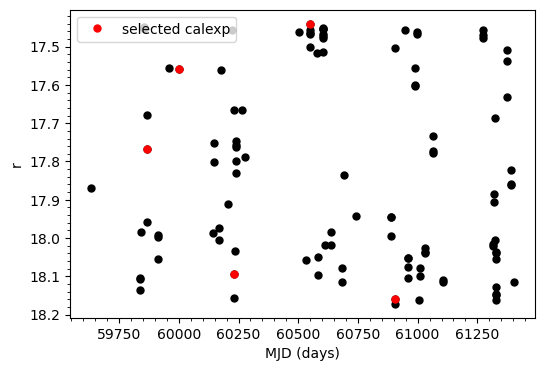

In [20]:
fig = plt.figure(figsize=(6, 4))
plt.plot(sorted_sources['expMidptMJD'], sorted_sources['psfMag'],
         'k.', ms=10)
plt.plot(sorted_sources[idx_select]['expMidptMJD'],
         sorted_sources[idx_select]['psfMag'],
         'r.', ms=10, label = 'selected calexp')
plt.minorticks_on()
plt.xlabel('MJD (days)')
plt.ylabel('r')
plt.gca().invert_yaxis()
plt.legend(loc = 2)
plt.show()

### 2.6 Save images

In [50]:
def update_wcs_center(wcs, new_center_sky):
    # Update the CRVAL values in the FITS header
    header = wcs.getFitsMetadata()
    header['CRVAL1'] = new_center_sky.getLongitude().asDegrees()
    header['CRVAL2'] = new_center_sky.getLatitude().asDegrees()
    
    # Create a new WCS from the updated header
    new_wcs = WCS(header)
    
    return new_wcs

def set_wcs_ticks_labels(ax, wcs):
    # Explicitly set tick positions and labels for the WCS axes
    # d. is degrees and .dd is the number of decimal points to display
    ax.coords[0].set_major_formatter('d.ddd')
    # positions on bottom left
    ax.coords[0].set_ticks_position('bl')
    ax.coords[0].set_axislabel('Right Ascension')

    ax.coords[1].set_major_formatter('d.ddd')
    ax.coords[1].set_ticks_position('bl')
    ax.coords[1].set_axislabel('Declination')

    # Set the maximum number of ticks for both axes
    ax.coords[0].set_ticks(spacing=2*u.arcsec)
    ax.coords[1].set_ticks(spacing=2*u.arcsec)


def get_cutout_image(butler, ra_deg, dec_deg, visit, detector, cutoutSideLength):
    """
    Get the cutout image information from butler.
    Specifically for calexp datatype.
    This should be followed by make_fig

    Input Parameters
    ----------
    ra : ra of source in degrees
    dec : dec of source in degrees
    visit : visit id
    detector : detector number
    cutoutSideLength : size of the cutout
    
    Returns
    ----------
    Cutout image information
    """
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
    
    radec = geom.SpherePoint(ra_deg, dec_deg, geom.degrees)
    
    dataId = {'visit': visit, 'detector': detector}  
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    
    print('calexp wcs: ', calexp_wcs)
    
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    print('xy: ', xy)
    print('bbox: ', bbox)
    
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)
    return cutout_image

def make_calexp_fig(cutout_image, out_name):
    """
    Create an image.
    should be followed with remove_figure
    
    Parameters
    ----------
    cutout_image : cutout_image from butler.get
    ra : ra of source in degrees
    dec : dec of source in degrees
    out_name : file name where you'd like to save it
    
    Returns
    ----------
    cutout image
    """
    # fig = plt.figure(figsize=(4, 4))
    # afw_display = afwDisplay.Display(frame=fig)
    # afw_display.scale('asinh', 'zscale')
    # afw_display.mtv(cutout_image.image)
    
#     cutout_wcs = cutout_image.getWcs()
#     radec = geom.SpherePoint(ra, dec, geom.degrees)
#     xy = geom.PointI(cutout_wcs.skyToPixel(radec))
    
#     afw_display.dot('x', xy.getX(), xy.getY(), size=1, ctype='orange')
#     plt.gca().axis('off')
#     plt.savefig(out_name)

    # Extract the WCS from the cutout image
    wcs = cutout_image.getWcs()
    
    # Get the CRVAL values from the WCS metadata
    crval1 = wcs.getFitsMetadata()['CRVAL1']
    crval2 = wcs.getFitsMetadata()['CRVAL2']
    
    # Create a new SpherePoint for the center of the image
    center_sky = geom.SpherePoint(crval1, crval2, geom.degrees)
    
    # Modify the center (for example, shift by 1 degree)
    new_center_sky = geom.SpherePoint(center_sky.getLongitude() + 1.0*geom.degrees,
                                      center_sky.getLatitude() + 1.0*geom.degrees)
    
    # Update the WCS with the new center
    new_wcs = update_wcs_center(wcs, new_center_sky)
    
    fig = plt.figure()
    ax = plt.subplot(projection=new_wcs)
    #plt.subplot(projection=WCS(cutout_image.getWcs().getFitsMetadata()))
    #plt.subplot(projection=new_wcs)
    
    
    calexp_extent = (cutout_image.getBBox().beginX, cutout_image.getBBox().endX,
                     cutout_image.getBBox().beginY, cutout_image.getBBox().endY)
    im = ax.imshow(abs(cutout_image.image.array),
                    cmap='gray', 
                    extent=calexp_extent,
                    origin='lower',
                    norm = matplotlib.colors.LogNorm(vmin=1e1, vmax = 1e5)
                    )#, vmax=5e4))
    #im = plt.imshow(cutout_image.image.array, cmap='gray', vmin=-200.0, vmax=5000,
    #            extent=calexp_extent, origin='lower')
    plt.colorbar(im, location='right', anchor=(0, 0.1))
    
    set_wcs_ticks_labels(ax, new_wcs)
    plt.savefig(out_name)
    
    return fig

def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.
    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.
    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure

    gc.collect()    # call th

calexp wcs:  FITS standard SkyWcs:
Sky Origin: (59.5503057281, -37.8218550602)
Pixel Origin: (2041.75, 2060.35)
Pixel Scale: 0.200047 arcsec/pixel
xy:  (3678, 2998)
bbox:  (minimum=(3653, 2973), maximum=(3702, 3022))


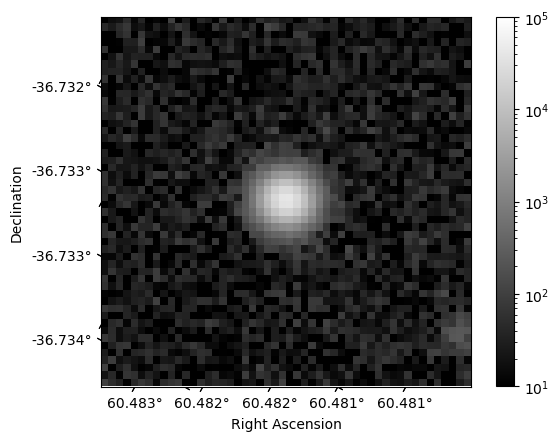

calexp wcs:  FITS standard SkyWcs:
Sky Origin: (59.3814532411, -37.7756685068)
Pixel Origin: (1852.77, 2153.35)
Pixel Scale: 0.199689 arcsec/pixel
xy:  (1219, 658)
bbox:  (minimum=(1194, 633), maximum=(1243, 682))


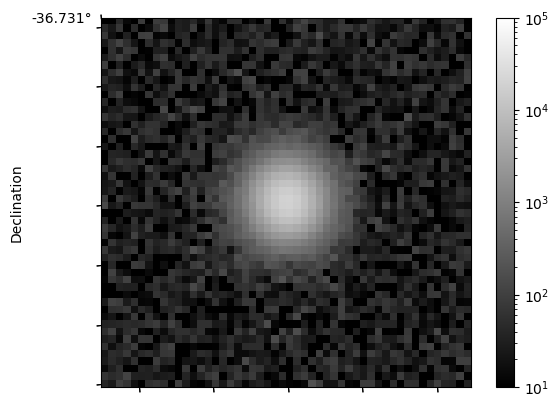

calexp wcs:  FITS standard SkyWcs:
Sky Origin: (59.4596635784, -37.7125600724)
Pixel Origin: (1863.37, 2055.09)
Pixel Scale: 0.199887 arcsec/pixel
xy:  (2062, 1627)
bbox:  (minimum=(2037, 1602), maximum=(2086, 1651))


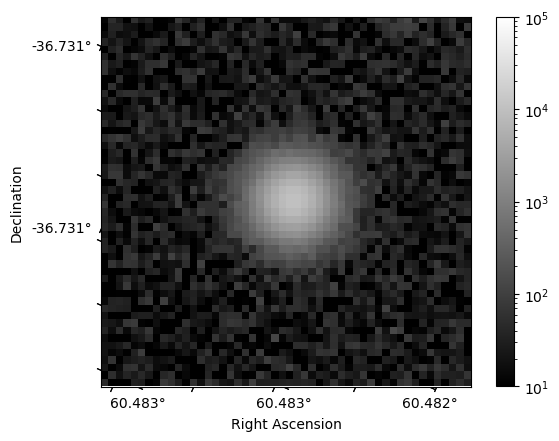

calexp wcs:  FITS standard SkyWcs:
Sky Origin: (59.3999708583, -37.7178027853)
Pixel Origin: (2023.5, 2102.39)
Pixel Scale: 0.199781 arcsec/pixel
xy:  (2785, 1186)
bbox:  (minimum=(2760, 1161), maximum=(2809, 1210))


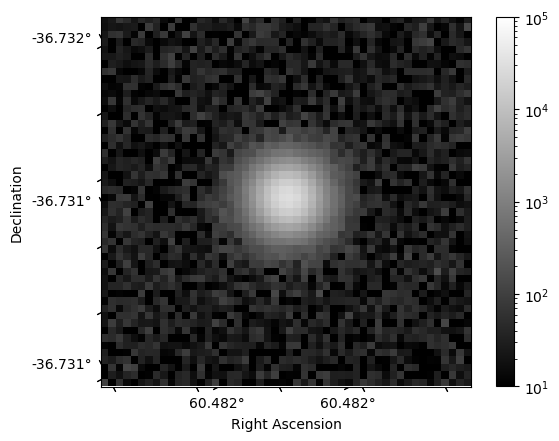

calexp wcs:  FITS standard SkyWcs:
Sky Origin: (59.4900575074, -37.6747776780)
Pixel Origin: (2071.07, 2110.74)
Pixel Scale: 0.199677 arcsec/pixel
xy:  (1964, 1071)
bbox:  (minimum=(1939, 1046), maximum=(1988, 1095))


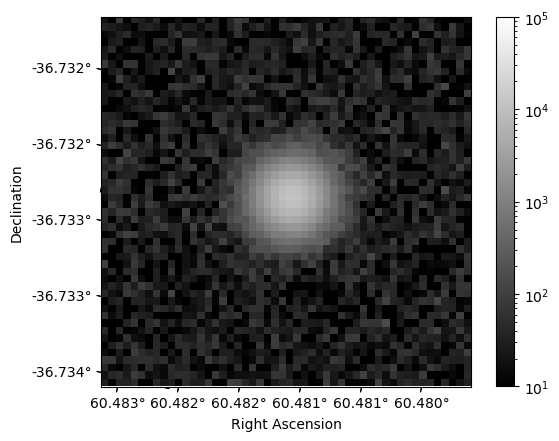

In [51]:
# main directory
batch_dir = './variable_stars_output/' 

'''
star_id = diaobjectID # in sree's OG example, this was the object ID not the diaObjID, so maybe change
star_ccdid = 662532066

calexp_image = get_cutout_image(butler, 59.4814837, -37.7323315, 662532, 66, 'g', 50, datasetType='calexp')
figout = make_calexp_fig(calexp_image, 59.4814837, -37.7323315, batch_dir+"/images/"+str(star_id)+"_"+str(star_ccdid)+".png")
''' 

# 
figout_data = {"sourceId": diaobjectID}
'''
if "coord_ra" in fields_to_add:
    figout_data["coord_ra"] = stars_ra[j]
if "coord_dec" in fields_to_add:
    figout_data["coord_dec"] = stars_dec[j]
'''
cutouts = []
    
for i, idx in enumerate(idx_select):
    star_ra = sorted_sources['ra'][idx]
    star_dec = sorted_sources['decl'][idx]
    star_visitid = sorted_sources['visitId'][idx]
    star_detector = sorted_sources['detector'][idx]
    star_id = sorted_sources['diaObjectId'][idx] # WAS objectId
    star_ccdid = sorted_sources['ccdVisitId'][idx]

    calexp_image = get_cutout_image(butler,
                                    star_ra,
                                    star_dec,
                                    star_visitid,
                                    star_detector,
                                    50) 
    figout = make_calexp_fig(calexp_image,
                             batch_dir+"/images/"+str(star_id)+"_"+str(star_ccdid)+".png")
    plt.show()
    remove_figure(figout)
    
    
    
    figout_data['location:image_'+str(i)] = str(star_id)+"_"+str(star_ccdid)+".png"
    figout_data['diaObjectId:image_'+str(i)] = str(star_id)
    figout_data['filename'] = str(star_id)+"_"+str(star_ccdid)+".png"
        
#cutouts.append(figout_data)

# manifest file
df_manifest = pd.DataFrame(data = figout_data, index=[0])


    
#df_manifest = pd.concat(df_final) # final manifest file with all variable stars
outfile = batch_dir+"images/manifest.csv"
df_manifest.to_csv(outfile, index=False, sep=',')


### 2.7 Display images in notebook
Do this using the image directory that you've already saved the images to: `variable_stars_output/images`

star 1567428592185376787


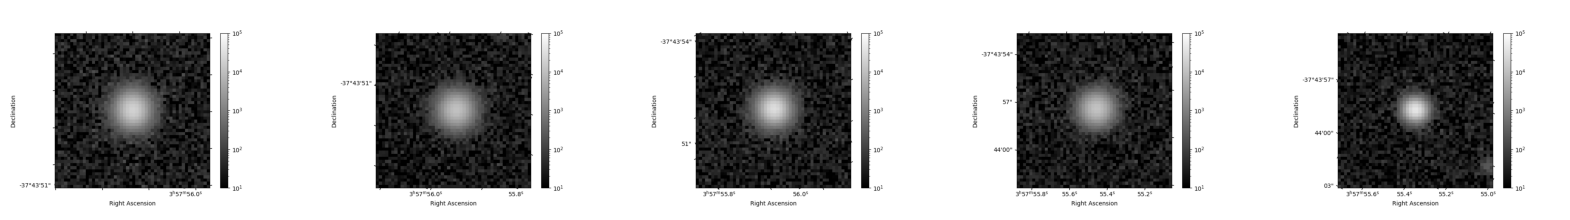

only one star


In [23]:
image_dir = 'variable_stars_output/images/'
num_variable_images = 5
stars_matchid_list = [diaobjectID]

star_name = np.zeros((1, num_variable_images))
star_name = []
for i, id_star in enumerate(stars_matchid_list):
    # go through and sort by ccdID so that they are in order of time
    # DOUBLE CHECK THAT THIS IS TIME ORDER
    ccdID_list = []
    for j, file in enumerate(os.listdir(image_dir)):
        if str.split(file,'.')[1] == 'png' and str.split(file,'_')[0] == str(id_star):
            star_name.append(str(id_star)+'_'+str(int(str.split(str.split(file,'_')[1],'.')[0]))+'.png')

# Okay now go through and plot each of these
fig, axs = plt.subplots(1,5, figsize = (20,20))
print('star', stars_matchid_list[0])
for j in range(num_variable_images):
    image = mpimg.imread(image_dir + star_name[j])
    axs[j].imshow(image)#, norm = matplotlib.colors.LogNorm())
    axs[j].axis('off')
plt.show()

try:
    print('star', stars_matchid_list[1])
    fig, axs = plt.subplots(1,5, figsize = (20,20))

    for j in range(num_variable_images):
        image = mpimg.imread(image_dir + star_name[j+num_variable_images])
        axs[j].imshow(image)
        axs[j].axis('off')
    plt.show()

except IndexError: # which will happen if you have only one star
    print('only one star')


The third and fifth image should be the brightest.

### A word of caution
Note that because we're using calexp images here, they have not been aligned like individual visits that are combined in a deepcoadd image. Therefore, the pixelscale is not guaranteed to be the same from one image to the next and the astrometry is not guaranteed to align. 

## 3. Send manifest to Zooniverse

In [ ]:
cutout_dir = batch_dir+"images/"
subject_set_name = "test_flipbook" 
cit_sci_pipeline.send_image_data(subject_set_name, cutout_dir)